In this project, departure times for units at port of Trieste is predicted via various regression models. In reality, this information is useful for our optimization project, where we assume 5 hours as a fixed duration after arrival of the ship to roro port. But this time may differentiate according to various factors and can be predicted up to a certain degree. With this model, prediction success was %50 higher according to fixed 5 hour assumption and 40% higher than mean value assumption. 

This version is the base version where all features of the model are listed and experiments were conducted. 

Best model is defined. Then all data is trained with this model. It is saved via a pickle model, so that we won't need to re-traing whole data in future. 

Then this pickled model is implemented into automated SQL version which retrieves real data from SQL views, makes predictions with pickled model, then saves the predictions into SQL database again. It will be shown in another version of the Jupyter notebook. 

In [1]:
#part where libraries loaded
import pandas as pd
import re
import numpy as np
pd.set_option('display.max_columns',40)
import more_itertools as mi
import timeit
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
from imblearn.under_sampling import RandomUnderSampler

np.random.seed(234)
pd.options.mode.chained_assignment = None

#part where saves the model results into a text file
text_file = open(r'C:\Users\ali.kilinc\Desktop\Roro Boşaltma Tahminleme\Output.txt',"w")

#part where some warnings are eliminated from console
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

start_time = timeit.default_timer()

unload = pd.read_csv(r'C:\Users\ali.kilinc\Desktop\Roro Boşaltma Tahminleme\Input_Data.csv', index_col= False, encoding= 'unicode_escape')

C:\Users\ali.kilinc\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ali.kilinc\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\ali.kilinc\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


In [3]:
outlier_removal = 1
inp_transform = 0
transform = 1
feature_selection = 0
regress = 0
finalize = 1

#unload = unload.iloc[0:1000,:]

unload['POSITION_CODE'] = unload['POSITION_CODE'].astype('str')
#csv loses leading 0's, but these 0 values are needed at the end for reporting issues. So I needed to refill these at the beginning
unload['POSITION_CODE'][unload['POSITION_CODE'].str[:1].str.isnumeric() == True] = unload['POSITION_CODE'][unload['POSITION_CODE'].str[:1].str.isnumeric() == True].str.zfill(8)

print(unload.info())

unload.dropna(subset=['RIDE_TYPE_ID'], inplace = True)

unload['POSITION_CODE'] = unload['POSITION_CODE'].astype('str')
unload['RIDE_TYPE_ID'] = unload['RIDE_TYPE_ID'].astype('int')
unload['RIDE_TYPE_ID'] = unload['RIDE_TYPE_ID'].astype('category')
unload['RIDE_TYPE_ID'] = unload['RIDE_TYPE_ID'].apply(str)
unload['SERVICE_TYPE'] = unload['SERVICE_TYPE'].astype('object')
unload['ROUTE_MODE'] = unload['ROUTE_MODE'].astype('category')
unload['DOC_TYPE'] = unload['DOC_TYPE'].astype('category')
unload['TRADELANE'] = unload['TRADELANE'].astype('category')
unload['FIRST_UNL'] = unload['FIRST_UNL'].astype('category')
unload['MIN_DUE'] = pd.to_datetime(unload['MIN_DUE'], format = '%d/%m/%Y %H:%M:%S')
unload['STARTED_DATE'] = pd.to_datetime(unload['STARTED_DATE'], format = '%d/%m/%Y %H:%M:%S')
unload['ARRIVAL_DATE'] = pd.to_datetime(unload['ARRIVAL_DATE'], format = '%d/%m/%Y %H:%M:%S')

unload['UNL_MONTH'] = unload['ARRIVAL_DATE'].dt.month.astype('category')
unload['UNL_MONTH'] = unload['UNL_MONTH'].apply(str)
unload['UNL_DAY'] = (unload['ARRIVAL_DATE'].dt.weekday + 1).astype('category')
unload['UNL_DAY'] = unload['UNL_DAY'].apply(str)
unload['UNL_HOUR'] = unload['ARRIVAL_DATE'].dt.hour.astype('category')


sub_bins = [0, 2, 5, 8, 11, 14, 17, 20, 23]
sub_labels = [1,2,3,4,5,6,7,8]
unload['UNL_HOUR'] = pd.cut(unload['UNL_HOUR'], bins=sub_bins, labels=sub_labels, include_lowest = True)
unload['UNL_HOUR'] = unload['UNL_HOUR'].apply(str)
print(unload['UNL_HOUR'].head(5))


#!!!!!!!! IT IS THE TRANSFORMATION OF CYCLICAL VARIABLES LIKE MONTH AND QUARTER. ONE-HOT IS AN OPTION BUT IT IS MUCH MORE BETTER THAN ENCODING
unload['UNL_MONTH_X'] = np.sin(2*np.pi*unload['UNL_MONTH'].astype(int)/12)
unload['UNL_MONTH_Y'] = np.cos(2*np.pi*unload['UNL_MONTH'].astype(int)/12)

unload['UNL_DAY_X'] = np.sin(2*np.pi*unload['UNL_DAY'].astype(int)/7)
unload['UNL_DAY_Y'] = np.cos(2*np.pi*unload['UNL_DAY'].astype(int)/7)

unload['UNL_HOUR_X'] = np.sin(2*np.pi*unload['UNL_HOUR'].astype(int)/len(sub_labels))
unload['UNL_HOUR_Y'] = np.cos(2*np.pi*unload['UNL_HOUR'].astype(int)/len(sub_labels))

unload.drop(columns = ['UNL_MONTH', 'UNL_DAY', 'UNL_HOUR'], axis = 1, inplace = True)

""" # General function for this transformation
def encode(data, col, max_val): # max val is theoretical maximum of column, for month it is 12, for day of year it is 365 etc.
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data
"""


unload['TIME_DUE'] = (round((unload['MIN_DUE'] - unload['ARRIVAL_DATE']).dt.seconds/60,0)
                            + (unload['MIN_DUE'] - unload['ARRIVAL_DATE']).dt.days*24*60).astype('int')

unload['TIME_WAITING'] = (round((unload['STARTED_DATE'] - unload['ARRIVAL_DATE']).dt.seconds/60,0)
                            + (unload['STARTED_DATE'] - unload['ARRIVAL_DATE']).dt.days*24*60).astype('int')

#sns.distplot(unload['TIME_WAITING'], hist = True, kde = True)
#plt.show()

unload[['T_CUST_TRI', 'TRIESTE_CNT', 'LANECNT', 'TIME_DUE']] = unload[['T_CUST_TRI', 'TRIESTE_CNT', 'LANECNT', 'TIME_DUE']].astype(int)

drop_false_wait = unload[(unload['TIME_WAITING'] < 10) | (unload['TIME_WAITING'] > 15000)].index
unload.drop(index = drop_false_wait, axis = 0, inplace=True)

drop_false_due = unload[(unload['TIME_DUE'] < -30000) | (unload['TIME_DUE'] > 30000)].index
unload.drop(index = drop_false_due, axis = 0, inplace = True)

unload['DOC_TYPE'] = np.where(~unload['DOC_TYPE'].isin(['T-1', 'TR']), 'oth', unload['DOC_TYPE'])
print(unload['DOC_TYPE'].value_counts())
#contains also can be used I think as an alternative
#why it is not working, work on it. For numeric condition like len(x) < 5 it is working.
#unload['DOC_TYPE'] = unload['DOC_TYPE'].replace(unload.groupby('DOC_TYPE').filter(lambda x: unload['DOC_TYPE'].isin(['T-1', 'TR']) == False)['DOC_TYPE'], 'oth')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20368 entries, 0 to 21705
Data columns (total 21 columns):
POSITION_CODE    20368 non-null object
ARRIVAL_DATE     20368 non-null datetime64[ns]
RIDE_TYPE_ID     20368 non-null category
SERVICE_TYPE     20368 non-null object
ROUTE_MODE       20368 non-null category
T_CUST_TRI       20368 non-null int32
DOC_TYPE         20368 non-null object
MIN_DUE          20368 non-null datetime64[ns]
TRIESTE_CNT      20368 non-null int32
LANECNT          20368 non-null int32
TRADELANE        20368 non-null category
FIRST_UNL        20368 non-null category
STARTED_DATE     20368 non-null datetime64[ns]
UNL_MONTH_X      20368 non-null float64
UNL_MONTH_Y      20368 non-null float64
UNL_DAY_X        20368 non-null float64
UNL_DAY_Y        20368 non-null float64
UNL_HOUR_X       20368 non-null float64
UNL_HOUR_Y       20368 non-null float64
TIME_DUE         20368 non-null int32
TIME_WAITING     20368 non-null int32
dtypes: category(4), datetime64[ns](3),

Above code is for redefining variable types, analysing their distributions and removing some of the absurd values. 

In [4]:
#In this part, data analysis is conducted with vaious graphs like histograms. 
"""
fig, ax = plt.subplots(2,4)

ax[0,0] = unload['RIDE_TYPE_ID'].value_counts().sort_index().plot.bar(title='Ride Type Hist', ax=ax[0,0])
ax[0,1] = unload['SERVICE_TYPE'].value_counts().plot.bar(title='Service Type Hist', ax=ax[0,1])
ax[0,2] = unload['DOC_TYPE'].value_counts().plot.bar(title='Doc Type Hist', ax=ax[0,2])
ax[0,3] = unload['TRADELANE'].value_counts().plot.bar(title='Tradelane Hist', ax=ax[0,3])
ax[1,0] = unload['FIRST_UNL'].value_counts().plot.bar(title='First Unload Hist', ax=ax[1,0])
ax[1,1] = unload['UNL_MONTH'].value_counts().plot.bar(title='Month Hist', ax=ax[1,1])
ax[1,2] = unload['UNL_DAY'].value_counts().plot.bar(title='Day Hist', ax=ax[1,2])
ax[1,3] = unload['UNL_HOUR'].value_counts().sort_index().plot.bar(title='Hour Hist', ax=ax[1,3])

fig2, ax2 = plt.subplots(2,2)

ax2[0,0] = sns.distplot(unload['T_CUST_TRI'], ax=ax2[0,0])
ax2[0,1] = sns.distplot(unload['TRIESTE_CNT'], hist=True, ax=ax2[0,1])
ax2[1,0] = sns.distplot(unload['TIME_DUE'], hist=True, ax=ax2[1,0])
ax2[1,1] = sns.distplot(unload['LANECNT'], hist=True, ax=ax2[1,1])
"""
print(unload.info())
print(unload.describe(include='all'))
print(unload.columns)
print(unload.head(10))
print(unload.tail(10))

# drop=True makes ure that we are not keeping old indexes as a column, Drops that old index column
unload.dropna(inplace=True)
unload.reset_index(drop=True, inplace = True)
print(unload.info())

#x and y variables are divided. Some of the unnecessary variables are dropped. Also some of them are removed acording to variable importances analysis.
df_y = unload['TIME_WAITING']
df_x = unload.drop(columns = ['ARRIVAL_DATE', 'STARTED_DATE', 'MIN_DUE', 'POSITION_CODE', 'TIME_WAITING'], axis=1)

#df_x.drop(columns = ['TRIESTE_CNT', 'T_CUST_TRI', 'SERVICE_TYPE', 'LANECNT', 'TRADELANE', 'DOC_TYPE', 'UNL_HOUR', 'UNL_DAY', 'UNL_MONTH', 'RIDE_TYPE_ID', 'FIRST_UNL'], axis = 1, inplace = True)
df_x.drop(columns = ['TRIESTE_CNT', 'T_CUST_TRI', 'SERVICE_TYPE', 'LANECNT', 'TRADELANE', 'DOC_TYPE'], axis = 1, inplace = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20368 entries, 0 to 21705
Data columns (total 21 columns):
POSITION_CODE    20368 non-null object
ARRIVAL_DATE     20368 non-null datetime64[ns]
RIDE_TYPE_ID     20368 non-null category
SERVICE_TYPE     20368 non-null object
ROUTE_MODE       20368 non-null category
T_CUST_TRI       20368 non-null int32
DOC_TYPE         20368 non-null object
MIN_DUE          20368 non-null datetime64[ns]
TRIESTE_CNT      20368 non-null int32
LANECNT          20368 non-null int32
TRADELANE        20368 non-null category
FIRST_UNL        20368 non-null category
STARTED_DATE     20368 non-null datetime64[ns]
UNL_MONTH_X      20368 non-null float64
UNL_MONTH_Y      20368 non-null float64
UNL_DAY_X        20368 non-null float64
UNL_DAY_Y        20368 non-null float64
UNL_HOUR_X       20368 non-null float64
UNL_HOUR_Y       20368 non-null float64
TIME_DUE         20368 non-null int32
TIME_WAITING     20368 non-null int32
dtypes: category(4), datetime64[ns](3),

In [5]:
#lists are created according to column types. Fixed and 0 columns are eliminated. At the and numerical and categorical variables are defined
num_colz = list(df_x._get_numeric_data().columns)

fix_cols = []
for col in df_x.columns:
    if df_x[col].nunique() == 1:
        fix_cols.append(col)
    else:
        pass

emp_cols = []
for col in df_x.columns:
    if df_x[col].count() > 0:
        pass
    else:
        emp_cols.append(col)

cat_colz = list(set(df_x.columns) - set(num_colz) - set(emp_cols) - set(fix_cols))
#this structure is used to reorder a list according to order of original df_x order. Because Set( is orderder according to alphabet)
cat_colz = [item for item in df_x.columns if item in cat_colz]

num_colz = list(set(num_colz) - set(fix_cols) - set(emp_cols))
num_colz = [item for item in df_x.columns if item in num_colz]

enc_colz = []

df_x.drop(columns = list(emp_cols+fix_cols), axis = 1, inplace = True)

cat_dims = [df_x.columns.get_loc(i) for i in cat_colz]
num_dims = [df_x.columns.get_loc(i) for i in num_colz]
print(df_x.columns)
print(cat_colz)
print(num_colz)
print(cat_dims)
print(num_dims)

df_x = pd.DataFrame(df_x, columns = df_x.columns)
df_y = pd.DataFrame(df_y, columns = ['TIME_WAITING'])
print(df_x.info())

#shuffling the data which will be used in prediction algorithm. X and Y values are shuffled with same indexes so that the protedt the correct orders.
for i in range(10):
    idx = np.random.permutation(df_x.index)
    df_x = df_x.reindex(idx)
    df_y = df_y.reindex(idx)

Index(['RIDE_TYPE_ID', 'FIRST_UNL', 'UNL_MONTH_X', 'UNL_MONTH_Y', 'UNL_DAY_X',
       'UNL_DAY_Y', 'UNL_HOUR_X', 'UNL_HOUR_Y', 'TIME_DUE'],
      dtype='object')
['RIDE_TYPE_ID', 'FIRST_UNL']
['UNL_MONTH_X', 'UNL_MONTH_Y', 'UNL_DAY_X', 'UNL_DAY_Y', 'UNL_HOUR_X', 'UNL_HOUR_Y', 'TIME_DUE']
[0, 1]
[2, 3, 4, 5, 6, 7, 8]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20368 entries, 0 to 20367
Data columns (total 9 columns):
RIDE_TYPE_ID    20368 non-null category
FIRST_UNL       20368 non-null category
UNL_MONTH_X     20368 non-null float64
UNL_MONTH_Y     20368 non-null float64
UNL_DAY_X       20368 non-null float64
UNL_DAY_Y       20368 non-null float64
UNL_HOUR_X      20368 non-null float64
UNL_HOUR_Y      20368 non-null float64
TIME_DUE        20368 non-null int32
dtypes: category(2), float64(6), int32(1)
memory usage: 1.0 MB
None


<Figure size 432x288 with 0 Axes>

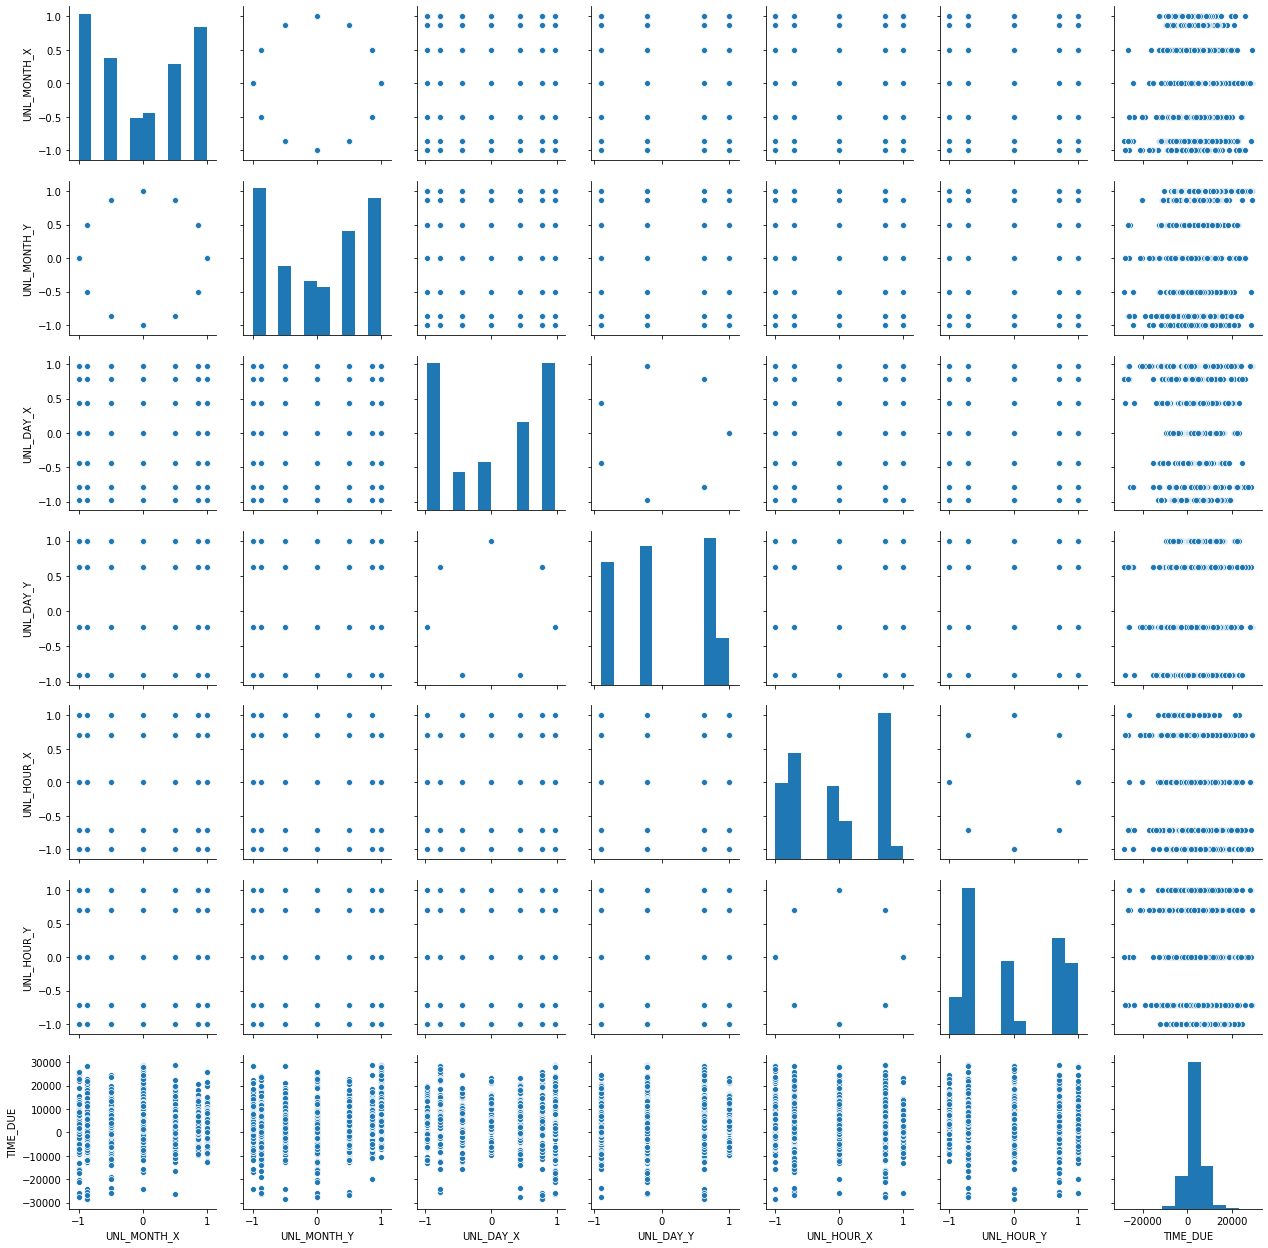

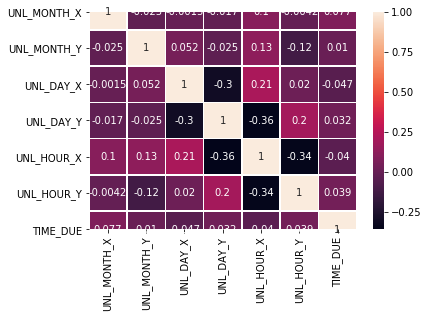

In [7]:
plt.figure()
sns.pairplot(df_x[num_colz])

plt.figure()
sns.heatmap(df_x[num_colz].corr(),annot=True, linewidth=0.5)

In [8]:
if outlier_removal == 1:
    #Isolation Forest is actually an anomaly detection algorithm, unsupervised like clustering
    #Consider using it inside CV pipeline while validating models, it has the risk of data leakage
    #So, it takes input features mainly into consideration, to detect if there is a feature combination which is very far away from the normal
    #It needs categorical preprocessing, mostly one hot encoded. For numerical, not needed probably
    #If it is used as a main algorithm, of course train-test split is important. But I am using it as preprocessing, it is most probably not important, it can be used on whole dataset.
    from pandas import get_dummies
    from sklearn.ensemble import IsolationForest
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.compose import ColumnTransformer
    
    clf = IsolationForest(contamination = 'auto')
    outlier_preprocessor = ColumnTransformer(transformers = [('cat', OneHotEncoder(sparse = True, handle_unknown = 'ignore'),cat_colz)],
                                                             remainder = 'passthrough')
    
    all_pipe = Pipeline(steps = [('prepro', outlier_preprocessor)])
        
    #df_x_ohe = all_pipe.fit_transform(df_x)
    df_x_ohe = get_dummies(df_x, columns = cat_colz)
    
    clf.fit(df_x_ohe)
    df_x_ohe['anomaly'] = clf.predict(df_x_ohe)
    anomaly=df_x_ohe.loc[df_x_ohe['anomaly']==-1]
    anomaly_index=list(anomaly.index)

    df_x, df_y = df_x.drop(anomaly_index), df_y.drop(anomaly_index)
    #df_x, df_y = df_x[df_x_ohe['anomaly'] == 1], df_y[df_x_ohe['anomaly'] == 1]



In [9]:
#it is valuable to transform independent variables to decrease skewness etc
if inp_transform == 1:
    tr_cols = ['LANECNT']
    df_x[tr_cols] = np.log1p(df_x[tr_cols])
else:
    pass

#transformation of the target variable
if transform == 1:
    #stats.probplot(df_y.values.ravel(),plot=plt)
    #sns.distplot(df_y, hist = False, kde = True)
    #plt.show()
    #df_y = np.log1p(df_y + 10) # iyi sonuç
    #df_y = np.log1p(df_y + 10000)
    print(df_y.head(5))
    df_y = np.log(df_y)
    print(df_y.head(5))
    #df_y = pow(df_y, 0.125)
    #stats.probplot(df_y.values.ravel(),plot=plt)
    #sns.distplot(df_y, hist = False, kde = True)
    #plt.show()
else:
    pass

       TIME_WAITING
12667           305
20274          3732
18390          4158
3952           2990
13078           185
       TIME_WAITING
12667      5.720312
20274      8.224700
18390      8.332789
3952       8.003029
13078      5.220356


In [10]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, Normalizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostRegressor, Pool, FeaturesData
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score
from xgboost import XGBClassifier
import sklearn.metrics as m
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostRegressor
import category_encoders as ce       
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor, LinearRegression, Lasso, Ridge, ElasticNet, HuberRegressor, Lars, RANSACRegressor, PassiveAggressiveRegressor
from xgboost import XGBRegressor
import pickle
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


def col_ind_get(prep, all_cols, num_cols, cat_cols, enc_cols):
    
    pre_all_cols = []
    pre_cat_cols = []
    pre_cat_ind = []
    
    cat_cols = list(set(cat_cols) - set(enc_cols))
    
    for i in range(len(prep.transformers)):
        
        pre_all_cols.extend(prep.transformers[i][2])
    
    pre_cat_cols = [item for item in pre_all_cols if item in cat_cols]
    pre_cat_ind = [i for i in range(len(pre_all_cols)) if pre_all_cols[i] in cat_cols]
    pre_num_cols = [item for item in pre_all_cols if item in num_cols]
    pre_num_ind = [i for i in range(len(pre_all_cols)) if pre_all_cols[i] in num_cols]
    
    return pre_all_cols, pre_cat_cols, pre_cat_ind, pre_num_cols, pre_num_ind

if feature_selection == 1:

    models = dict()
    #you have to write the name of pipeline estimator object before parameters in grid search with pipeline
    paramslas = {
            'est__alpha': [0.001, 0.01, 0.1, 1],
            'est__max_iter': np.linspace(0, 3000, 3, endpoint = True),
            'est__tol': [0.0001, 0.001, 0.01]
                }
    
    paramsrf = {
            'est__max_depth':[5, 9, 18, 32],
            'est__n_estimators': [10, 50, 100, 200],
            'est__min_samples_split': [0.1, 1.0, 2],
            'est__min_samples_leaf': [0.1, 0.5, 1]
            }
    
    paramscats = {
            'est__depth': np.linspace(4,10,3,endpoint=True),
            'est__iterations':[100,250],
            'est__learning_rate':[0.005,0.01],
            'est__bagging_temperature': [0,35],
            'est__border_count':[25,75]
            }
    
    paramscat = {
            'est__depth': np.linspace(10,10,1,endpoint=True),
            'est__iterations':[500],
            'est__learning_rate':[0.01],
            'est__bagging_temperature': [20],
            'est__border_count':[75]
            }


    #models['las'] = [Lasso(), paramslas]
    #models['rf'] = [RandomForestRegressor(), paramsrf]
    models['catb'] = [CatBoostRegressor(verbose = 0), paramscat]
    #If you have numerical categoric value, you may get TypeError: object of type 'int' has no len()
    #
    
    for key, value in models.items():
                
        start_time = timeit.default_timer()
        
        scorer = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
        
        if key == 'catb':
            #at preprocessing section, one hot encoding is not suggested for catboost. ıf you need it, use one_hot_max_size parameter inside estimator 
            
            numeric_transformer = Pipeline(steps=[('scl', MinMaxScaler(feature_range = (0,1)))])
            #!!!column transformer changes column indices according to operation order inside.
            #for CATBOOST you either should give index for cat_features, so this index shouldn't change inside pipeline. Or
            #you can give column names, this will need df_x to be a dataframe with column names inside fit or a pool object.
            #gridsearchCV will not accept pool object and it will raise error, so you would need a way of defining column names after preprocessing
            #and transforming this array output into a dataframe before estimator step. It is an open issue for me, couldn't figure it out

            
            preprocessor = ColumnTransformer(transformers = [('cat', 'passthrough',cat_colz),
                                            ('num', numeric_transformer, num_colz)], remainder = 'passthrough')
            pass_colz = cat_colz
            
            #If I define cat_cols inside dictionary upside, it is stored and can't be changed. So, changing the corrected dimensions afterwards will not effect it
            #and it will go on rising error. But If you define the catboost parameter inside grid_search.fit with est__ preverb it will use updated cat indexes
            all_pipe = Pipeline(steps = [('prep', preprocessor), ('est', value[0])])
            
            #all_pipe = Pipeline(steps = [('prep', preprocessor)])
            #!!! cat dims transormer nedeniyle değişiyor, ya cat dims yenilemem lazım preprocess sonrası, ya da col names üzerinden gidip
            #col names eklemem lazım transformed df_X üzerine ve dataframe haline getirmem lazım estimator öncesi
            pre_all_cols, pre_cat_cols, pre_cat_ind, pre_num_cols, pre_num_ind = col_ind_get(preprocessor, df_x.columns, num_colz, cat_colz, enc_colz)

            #print(all_pipe.named_steps['prep'].transformers[0].get_feature_names())
            
            search_space = value[1]
            #POOL needs all cat_features to be string, not numerical, even they are labels of categories it is forbidden.
            #also pool datatype is not suitable for gridsearchcv, it will raise singleton array error
            #df_x[['RIDE_TYPE_ID', 'UNL_MONTH', 'UNL_DAY', 'UNL_HOUR']] = df_x[['RIDE_TYPE_ID', 'UNL_MONTH', 'UNL_DAY', 'UNL_HOUR']].astype('str')
            #df_x['UNL_DAY'] = df_x['UNL_DAY'].astype('str')
            #REFIT = True for gridsearchcv means, at the end train with full data with best estimator, to get final model, 
            #grid_search.best_estimator_ can be used as model file for Pickle Dump. It is the best model estimator, 
            #pooled = Pool(data = FeaturesData(
            #                                     num_feature_data = np.array(df_x[num_colz], dtype = np.float32), 
            #                                     cat_feature_data = np.array(df_x[cat_colz], dtype= 'object'), 
            #                                     num_feature_names = num_colz, 
            #                                     cat_feature_names = cat_colz),
            #              label =  df_y.values.ravel().tolist())

            grid_search = GridSearchCV(all_pipe, search_space, cv=5, verbose=1, refit = 'neg_mean_squared_error', scoring = scorer, return_train_score = True, n_jobs = -1)
            
            #grid_search.fit(pooled, est__cat_features = cat_colz)

            grid_search.fit(df_x, y = df_y.values.ravel(), est__cat_features = pre_cat_ind)
            
        else:
            
            preprocessor = ColumnTransformer(transformers = [('num', MinMaxScaler(feature_range = (0,1)), num_colz), 
                                                             ('cat', OneHotEncoder(sparse = True, handle_unknown = 'ignore'), cat_colz)])
        
            all_pipe = Pipeline(steps = [('prep', preprocessor),('est', value[0])])
        
            search_space = value[1]
        
        
            #njobs = -1 uses 2 cores (all available) and 4 threads; consumes 100% of CPU. But it is faster absolutely. Njobs = 1 uses 1 core only, slower but consumes less CPU
            grid_search = GridSearchCV(all_pipe, search_space, cv=3, verbose=1, refit = 'neg_mean_squared_error', scoring = scorer, return_train_score = True, n_jobs = -1)
            #scoring option is for defining multiple scorers, otherwise null is OK
            #refit must be chosen if multi scorers is selected. But best_score_, best_params_ etc will give only the result of that metric, cant get multi scores
            #here REFIT option tells you which metric do you want to consider for best_params_ calculation(according to which metric)
            
            #numeric_pipe = make_pipeline(MinMaxScaler(feature_range = (0,1)))
            #categoric_pipe = make_pipeline(OneHotEncoder(sparse = True, handle_unknown='ignore'))
            #preprocessor = ColumnTransformer(transformers = [('num',numeric_pipe, num_cols), ('cat',categoric_pipe,cat_cols)])
            #all_pipe = make_pipeline(preprocessor, grid_search)
            #all_pipe.fit(df_x, df_y.values.ravel())

            grid_search.fit(df_x, df_y.values.ravel())
        
        #from the resulting parameters dictionary, we choose the index of best_param_ set. This index will help us the get best param value from subresults
        #metric results are in arraf form, in each array there is a list of results corresponding to the all parameter combinations. 
        ind = grid_search.best_index_      
        
        print("model = {}".format(key))
        print("train_mse = {}, test_mse ={}".format(grid_search.cv_results_['mean_train_neg_mean_squared_error'][ind], grid_search.cv_results_['mean_test_neg_mean_squared_error'][ind]))
        print("train_mae = {}, test_mae ={}".format(grid_search.cv_results_['mean_train_neg_mean_absolute_error'][ind], grid_search.cv_results_['mean_test_neg_mean_absolute_error'][ind]))
        #print("train_mse2 = {}, test_mse ={}".format(np.exp(grid_search.cv_results_['mean_train_neg_mean_squared_error'][ind]), np.exp(grid_search.cv_results_['mean_test_neg_mean_squared_error'][ind])), file = text_file)
        #print("train_mae2 = {}, test_mae ={}".format(np.exp(grid_search.cv_results_['mean_train_neg_mean_absolute_error'][ind]), np.exp(grid_search.cv_results_['mean_test_neg_mean_absolute_error'][ind])), file = text_file)
        
        print("train_r2 = {}, test_r2 = {}".format(grid_search.cv_results_['mean_train_r2'][ind], grid_search.cv_results_['mean_test_r2'][ind]))
        print("avg_fit_time = {}".format(grid_search.cv_results_['mean_fit_time'][ind]))
        #we are getting best_params_ from grid_search object still, it is valid
        print("best_params = {}".format(grid_search.best_params_))
        print("best_estimator = {}".format(grid_search.best_estimator_.named_steps['est']))
        
        """
        feat_imp = grid_search.best_estimator_.named_steps['est'].feature_importances_
        cat_encoded = list(grid_search.best_estimator_.named_steps['prep'].transformers_[1][1].get_feature_names(cat_cols))
        features = num_cols + cat_encoded
        feat_dict = sorted(zip(feat_imp, features), reverse = True)
        print(feat_dict)
        print(feat_dict[0:10])
        print([item[1] for item in [t for t in feat_dict if t[0] > 0.01]])
        print(list(filter(lambda x: x[0]> 0.01, feat_dict)))
        """
        
        
        print("---%0.1f minutes---" %((timeit.default_timer()-start_time)/60))
        print("...{}...".format(start_time))
        print("current_time = {}...".format(datetime.now()))
        print("current_time = {}...".format(datetime.now()))
        print("-----------------------------------")
        
        best_params = dict()
        best_params[key] = grid_search.best_params_
        
        best_results = dict()
        best_results[key] = [grid_search.cv_results_['mean_test_neg_mean_squared_error'][ind], grid_search.cv_results_['mean_test_neg_mean_absolute_error'][ind], grid_search.cv_results_['mean_test_r2'][ind]]
        
        importances = grid_search.best_estimator_.named_steps['est'].feature_importances_
        importances = [float(i) for i in importances]
        
        print(pre_all_cols)
        print(importances)
        print(list(zip(pre_all_cols, importances)))
        

Above part is for conducting feature selection analysis and defining feature importances. Some of the variables are removed from the dataset and experiments are conducted with remaining ones. 

In [11]:
if regress == 1:
    models = dict()
    
    paramsgbm = {
            'est__n_estimator': np.linspace(100,500,2,endpoint = True),
            'est__max_depth': np.linspace(1,9,3, endpoint=True, dtype = int),
            'est__min_child_weight':np.linspace(1, 9, 3, endpoint=True),
            'est__colsample_bytree': np.linspace(0.1,0.9,3,endpoint =True)
            }
    
    paramslr = {
                }
    
    paramslas = {
            'est__alpha': [0.001, 0.01, 0.1, 1],
            'est__max_iter': np.linspace(0, 3000, 3, endpoint = True),
            'est__tol': [0.0001, 0.001, 0.01]
                }
    
    paramsrid = {
            'est__alpha': [0.001, 0.01, 0.1, 1],
            'est__max_iter': np.linspace(0, 3000, 3, endpoint = True),
            'est__tol': [0.0001, 0.001, 0.01]
                }
    
    paramsela = {
            'est__alpha': [0.001, 0.01, 0.1, 1],
            'est__max_iter': np.linspace(0, 2000, 10, endpoint = True),
            'est__tol': [0.0001, 0.001, 0.01],
            'est__l1_ratio': np.linspace(0.25,0.75, 5, endpoint = True)
            }
    
    paramssgd = {
            'est__penalty':['none', 'l1','l2','elasticnet'],
            'est__max_iter': np.linspace(0.1, 3000, 3 ,endpoint = True), 
            'est__alpha': [0.001, 0.01, 0.1, 1],
            'est__n_iter_no_change':np.linspace(5, 10, 2, endpoint=True),
            'est__l1_ratio': np.linspace(0.25,0.75,3,endpoint = True)
            }
    
    paramssvr = {
            'est__kernel':['linera', 'poly', 'rbf'],
            'est__C': [0.1, 1, 10, 100],  
            'est__gamma': [1, 0, 0.1, 0.01]
            }
    
    paramsada = {
            'est__learning_rate': [0.01,0.1, 0.5, 0.9],
            'est__loss': ['linear', 'square', 'exponential'],
            'est__n_estimators': [10,25,50,100]
            }
    paramsrf = {
            'est__max_depth':[5, 9, 18, 32],
            'est__n_estimators': [10, 50, 100, 200],
            'est__min_samples_split': [0.1, 1.0, 2],
            'est__min_samples_leaf': [0.1, 0.5, 1]
            }
    
    paramslgb = {
            'est__max_depth':[5, 9, 18, 32],
            'est__learning_rate': [0.001, 0.01, 0.1],
            'est__n_estimators': [10, 50, 100, 200],
            'est__num_leaves': np.linspace(11,51,3,endpoint = True, dtype = int)
            }
    
    #models['gbm'] = [XGBRegressor(objective = 'reg:squarederror', booster = 'gbtree', seed = 23, learning_rate = 0.01), paramsgbm]
    models['lr'] = [LinearRegression(), paramslr]
    #models['las'] = [Lasso(), paramslas]
    #models['rid'] = [Ridge(), paramsrid]
    #models['ela'] = [ElasticNet(), paramsela]
    #models['huber'] = HuberRegressor()
    #models['lars'] = Lars()
    #models['passive'] = PassiveAggressiveRegressor()
    #models['ransac'] = RANSACRegressor()
    models['sgd'] = [SGDRegressor(random_state = 234), paramssgd]
    #models['svr'] = [SVR(), paramssvr]
    #models['ada'] = [AdaBoostRegressor(random_state = 234), paramsada]
    models['rf'] = [RandomForestRegressor(), paramsrf]
    models['lgb'] = [LGBMRegressor(), paramslgb]

    for key, value in models.items():
                
        start_time = timeit.default_timer()
        
        scorer = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']
        
        preprocessor = ColumnTransformer(transformers = [('num', MinMaxScaler(feature_range = (0,1)), num_colz), 
                                                         ('cat', OneHotEncoder(sparse = True, handle_unknown = 'ignore'), cat_colz)])
        all_pipe = Pipeline(steps = [('prep', preprocessor),('est', value[0])])
        
        search_space = value[1]
        
        #njobs = -1 uses 2 cores (all available) and 4 threads; consumes 100% of CPU. But it is faster absolutely. Njobs = 1 uses 1 core only, slower but consumes less CPU
        grid_search = GridSearchCV(all_pipe, search_space, cv=5, verbose=1, refit = 'neg_mean_squared_error', scoring = scorer, return_train_score = True, n_jobs = -1)
        #scoring option is for defining multiple scorers, otherwise null is OK
        #refit must be chosen if multi scorers is selected. But best_score_, best_params_ etc will give only the result of that metric, cant get multi scores
        #here REFIT option tells you which metric do you want to consider for best_params_ calculation(according to which metric)
        
        #REFIT = True for gridsearchcv means, at the end train with full data with best estimator, to get final model, 
        #grid_search.best_estimator_ can be used as model file for Pickle Dump. It is the best model estimator, 
        grid_search.fit(df_x, df_y.values.ravel())
        
        #from the resulting parameters dictionary, we choose the index of best_param_ set. This index will help us the get best param value from subresults
        #metric results are in arraf form, in each array there is a list of results corresponding to the all parameter combinations. 
        ind = grid_search.best_index_      
        
        print("model = {}".format(key), file = text_file)
        print("train_mse = {}, test_mse ={}".format(grid_search.cv_results_['mean_train_neg_mean_squared_error'][ind], grid_search.cv_results_['mean_test_neg_mean_squared_error'][ind]), file = text_file)
        print("train_mae = {}, test_mae ={}".format(grid_search.cv_results_['mean_train_neg_mean_absolute_error'][ind], grid_search.cv_results_['mean_test_neg_mean_absolute_error'][ind]), file = text_file)
        #print("train_mse2 = {}, test_mse ={}".format(np.exp(grid_search.cv_results_['mean_train_neg_mean_squared_error'][ind]), np.exp(grid_search.cv_results_['mean_test_neg_mean_squared_error'][ind])), file = text_file)
        #print("train_mae2 = {}, test_mae ={}".format(np.exp(grid_search.cv_results_['mean_train_neg_mean_absolute_error'][ind]), np.exp(grid_search.cv_results_['mean_test_neg_mean_absolute_error'][ind])), file = text_file)
        
        print("train_r2 = {}, test_r2 = {}".format(grid_search.cv_results_['mean_train_r2'][ind], grid_search.cv_results_['mean_test_r2'][ind]), file = text_file)
        print("avg_fit_time = {}".format(grid_search.cv_results_['mean_fit_time'][ind]), file = text_file)
        #we are getting best_params_ from grid_search object still, it is valid
        print("best_params = {}".format(grid_search.best_params_), file = text_file)
        print("---%0.1f minutes---" %((timeit.default_timer()-start_time)/60), file = text_file)
        print("...{}...".format(start_time), file = text_file)
        print("current_time = {}...".format(datetime.now()), file = text_file)
        print("current_time = {}...".format(datetime.now()))
        print("-----------------------------------", file = text_file)
        
        best_params = dict()
        best_params[key] = grid_search.best_params_
        
        best_results = dict()
        best_results[key] = [grid_search.cv_results_['mean_test_neg_mean_squared_error'][ind], grid_search.cv_results_['mean_test_neg_mean_absolute_error'][ind], grid_search.cv_results_['mean_test_r2'][ind]]


Experiments are conducted at above part. There are several regression models here and  grid search based cross validation scheme is used to determine best parameter sets for each algorithm, and assessing best algorithm among all.

In [13]:
if finalize == 1:
    
    #in this part, selected best algorithm details are defined and predictions are made according to it
    #lr = LinearRegression()
    lgbr = LGBMRegressor(learning_rate = 0.1, max_depth = 32, n_estimators = 200, num_leaves = 51)
    #sgdr = SGDRegressor(alpha = 0.01, l1_ratio = 0.25, max_iter = 1500.05, n_iter_no_change = 10.0, penalty = 'l1', random_state = 234)
    
    preprocessor = ColumnTransformer(transformers = [('num', MinMaxScaler(feature_range = (0,1)), num_colz), 
                                                         ('cat', OneHotEncoder(sparse = True, handle_unknown = 'ignore'), cat_colz)])
    
    all_pipe_final = make_pipeline(preprocessor, lgbr)
    
    all_pipe_final.fit(df_x, df_y.values.ravel())
    
    

    ##This pickle module saves the best algoritm, and there is no need to train it again afterwards.
    #with open(r'C:\Users\ali.kilinc\Desktop\Roro Boşaltma Tahminleme\best_model.pkl', 'wb') as f:
    #    pickle.dump(all_pipe_final, f)
    
    ##This pickle module runs the best pickled model, without any need of re-train whole dataset. 
    #with open(r'C:\Users\ali.kilinc\Desktop\Roro Boşaltma Tahminleme\best_model.pkl', 'wb') as f:
    #    final_model = pickle.load(open('best_model.pkl', 'rb'))
    
    
    pred = all_pipe_final.predict(df_x)
    df_x['real'] = np.exp(df_y)
    df_x['pred'] = np.exp(pred)
    
    print(df_x[['real', 'pred']].head(20))
    print(df_y.head(20))
    print(pred[:20])
    #print_excel = df_x.to_excel(r'C:\Users\ali.kilinc\Desktop\PredUnload.xlsx', index = None, header = True, sheet_name = 'FullTable')

text_file.close()

          real         pred
12667    305.0   628.719738
20274   3732.0  1637.785653
18390   4158.0  5332.210964
3952    2990.0  2932.558173
13078    185.0   571.902165
5469    1744.0  1149.590570
14977    766.0  2244.617533
19937   7997.0  4211.423757
11323   4019.0  2836.116212
11681   1987.0  2674.058704
5880    3180.0  2472.689486
7151    9555.0  1800.206823
10791    326.0   529.082715
12879    994.0  1436.471406
15872    434.0  1969.846828
14032    694.0  1581.282012
10603   2340.0  1421.564692
20002   3306.0  3013.332462
9854   12478.0  2286.978301
6385     960.0   548.511330
       TIME_WAITING
12667      5.720312
20274      8.224700
18390      8.332789
3952       8.003029
13078      5.220356
5469       7.463937
14977      6.641182
19937      8.986822
11323      8.298788
11681      7.594381
5880       8.064636
7151       9.164820
10791      5.786897
12879      6.901737
15872      6.073045
14032      6.542472
10603      7.757906
20002      8.103494
9854       9.431722
6385       6